In [1]:
import pandas as pd #đọc dữ liệu
import numpy as np #xử lý dữ liệu
import matplotlib.pyplot as plt #vẽ biểu đồ
from sklearn.preprocessing import MinMaxScaler #chuẩn hóa dữ liệu
from keras.callbacks import ModelCheckpoint # type: ignore #lưu lại huấn luyện tốt nhất
from tensorflow.keras.models import load_model # type: ignore #tải mô hình
from tensorflow.keras.optimizers import Adam # type: ignore
from tensorflow.keras.callbacks import EarlyStopping # type: ignore
from tensorflow.keras.regularizers import l2 # type: ignore

#các lớp để xây dựng mô hình
from keras.models import Sequential # type: ignore #đầu vào
from keras.layers import LSTM # type: ignore #học phụ thuộc
from keras.layers import Dropout # type: ignore #tránh học tủ
from keras.layers import Dense # type: ignore #đầu ra
from keras.layers import BatchNormalization, ReduceLROnPlateau # type: ignore

#kiểm tra độ chính xác của mô hình
from sklearn.metrics import r2_score  # Đo mức độ phù hợp
from sklearn.metrics import mean_absolute_error  # Đo sai số tuyệt đối trung bình
from sklearn.metrics import mean_absolute_percentage_error,mean_squared_error, f1_score  # Đo % sai số tuyệt đối trung bình

from pymongo import MongoClient

In [2]:

# Kết nối đến MongoDB
client = MongoClient('mongodb://localhost:27017/')
db = client['metadata']  
collection = db['FPT']  

# Chuyển dữ liệu thành DataFrame
df = pd.DataFrame(list(collection.find({}, {"_id": 0})))
df


,Ngay,GiaDieuChinh,GiaDongCua,KhoiLuongKhopLenh,GiaTriKhopLenh,KLThoaThuan,GtThoaThuan,GiaMoCua,GiaCaoNhat,GiaThapNhat,ThayDoi_GiaTri,ThayDoi_PhanTram
0,2006-12-15,12.61,441.0,265300,116997300,30000,12200000,441.0,441.0,441.0,0.0,0.00
1,2006-12-25,12.52,438.0,22140,9697320,30000,14060000,438.0,438.0,438.0,0.0,0.00
2,2006-12-28,13.72,480.0,144840,69127400,37620,17788380,470.0,480.0,470.0,0.0,0.00
3,2007-01-03,12.87,450.0,74660,0,0,0,450.0,450.0,440.0,0.0,0.00
4,2007-01-08,14.01,490.0,351470,90341000000,0,0,510.0,510.0,490.0,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...
4489,2024-12-17,148.00,148.0,5947500,885470000000,1418005,215262097500,150.1,150.5,147.7,-1.9,-1.27
4490,2024-12-13,149.50,149.5,3379800,506936000000,1485005,226230698500,149.5,150.9,149.4,-0.7,-0.47
4491,2024-12-18,148.70,148.7,2923400,435819000000,616040,91038708000,148.0,149.8,148.0,0.7,0.47
4492,2024-12-19,148.10,148.1,4805200,711171000000,1020254,153392128200,147.3,149.0,147.2,-0.6,-0.40


In [3]:
# Kiểm tra dữ liệu
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4494 entries, 0 to 4493
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Ngay               4494 non-null   object 
 1   GiaDieuChinh       4494 non-null   float64
 2   GiaDongCua         4494 non-null   float64
 3   KhoiLuongKhopLenh  4494 non-null   int64  
 4   GiaTriKhopLenh     4494 non-null   int64  
 5   KLThoaThuan        4494 non-null   int64  
 6   GtThoaThuan        4494 non-null   int64  
 7   GiaMoCua           4494 non-null   float64
 8   GiaCaoNhat         4494 non-null   float64
 9   GiaThapNhat        4494 non-null   float64
 10  ThayDoi_GiaTri     4494 non-null   float64
 11  ThayDoi_PhanTram   4494 non-null   float64
dtypes: float64(7), int64(4), object(1)
memory usage: 421.4+ KB


,GiaDieuChinh,GiaDongCua,KhoiLuongKhopLenh,GiaTriKhopLenh,KLThoaThuan,GtThoaThuan,GiaMoCua,GiaCaoNhat,GiaThapNhat,ThayDoi_GiaTri,ThayDoi_PhanTram
count,4494.000000,4494.000000,4.494000e+03,4.494000e+03,4.494000e+03,4.494000e+03,4494.000000,4494.000000,4494.000000,4494.000000,4494.000000
mean,24.392850,82.969993,1.087960e+06,8.906264e+10,2.494531e+05,1.988941e+10,82.988774,83.825000,82.170572,0.035932,0.066620
std,29.825946,83.762349,1.316909e+06,1.507212e+11,8.138787e+05,6.110453e+10,83.833554,84.531657,83.030210,1.166046,1.538896
min,2.110000,32.300000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,32.200000,32.600000,32.100000,-30.400000,-11.030000
25%,6.050000,47.200000,2.453875e+05,1.563641e+10,0.000000e+00,0.000000e+00,47.200000,47.600000,46.962500,-0.300000,-0.497500
50%,10.920000,56.000000,6.260600e+05,4.081850e+10,0.000000e+00,0.000000e+00,56.000000,56.500000,55.200000,0.000000,0.000000
75%,24.340000,84.200000,1.455698e+06,9.559925e+10,1.620550e+05,1.010000e+10,84.300000,85.000000,83.500000,0.400000,0.630000
max,150.500000,665.000000,1.370680e+07,1.782682e+12,2.276401e+07,1.126501e+12,665.000000,672.000000,665.000000,11.500000,7.000000


In [4]:
# Xử lý thời gian và sắp xếp dữ liệu
df['Ngay'] = pd.to_datetime(df['Ngay'], format='%Y-%m-%d')
df = df.sort_values(by='Ngay')

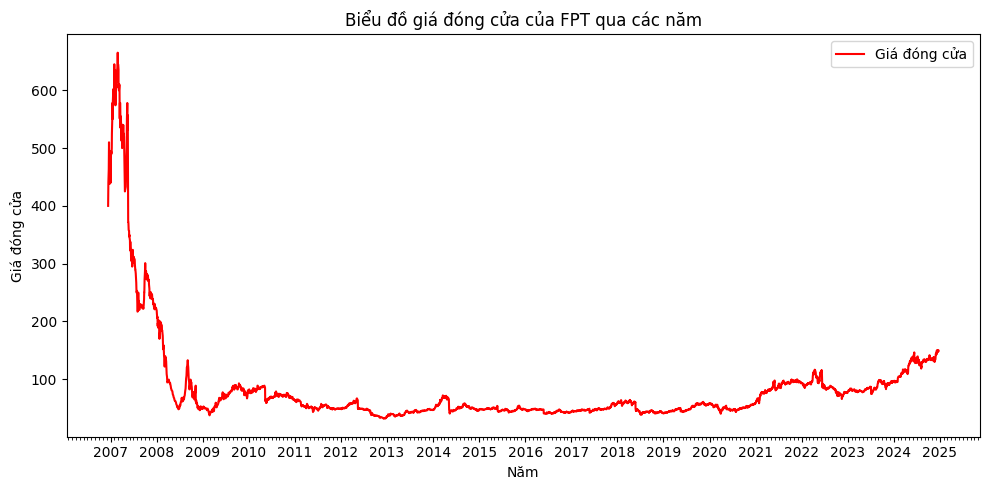

In [5]:
from matplotlib.dates import YearLocator, DateFormatter, MonthLocator # Thêm MonthLocator vào để sửa lỗi

# Lấy thông tin năm từ cột "Ngày"
df['Nam'] = df['Ngay'].dt.year

# Tạo đồ thị giá đóng cửa qua các năm
plt.figure(figsize=(10, 5))
plt.plot(df['Ngay'], df['GiaDongCua'], label='Giá đóng cửa', color='red')
plt.xlabel('Năm')
plt.ylabel('Giá đóng cửa')
plt.title('Biểu đồ giá đóng cửa của FPT qua các năm')
plt.legend(loc='best')

# Định dạng đồ thị hiển thị các ngày tháng theo năm-tháng
years = YearLocator()
yearsFmt = DateFormatter('%Y')
months = MonthLocator()  # Thêm dòng này để khai báo MonthLocator
plt.gca().xaxis.set_major_locator(years)
plt.gca().xaxis.set_major_formatter(yearsFmt)
plt.gca().xaxis.set_minor_locator(months)

plt.tight_layout()
plt.show()

In [6]:
# Chuyển đổi sang chỉ số thời gian
df1 = pd.DataFrame(df, columns=['Ngay', 'GiaDongCua'])
df1.index = df1['Ngay']
df1.drop('Ngay', axis=1, inplace=True)

In [7]:
df1

,GiaDongCua
Ngay,
2006-12-13,400.0
2006-12-14,420.0
2006-12-15,441.0
2006-12-18,463.0
2006-12-19,486.0
...,...
2024-12-16,149.9
2024-12-17,148.0
2024-12-18,148.7


In [8]:
# Chia tập dữ liệu
data = df1.values
train_data = data[:int(len(df) * 0.8)]
test_data = data[int(len(df) * 0.8):]

In [9]:
data

array([[400. ],
       [420. ],
       [441. ],
       ...,
       [148.7],
       [148.1],
       [149.5]])

In [10]:
# Chuẩn hóa dữ liệu
sc = MinMaxScaler(feature_range=(0, 1))
sc_train = sc.fit_transform(data)

In [11]:
# Tạo cửa sổ thời gian cho tập train
x_train, y_train = [], []
for i in range(50, len(train_data)):
    x_train.append(sc_train[i - 50:i, 0])  # 50 giá trị trước đó
    y_train.append(sc_train[i, 0])  # Giá trị tiếp theo
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [12]:
# Tạo cửa sổ thời gian cho tập test
x_test, y_test = [], []
for i in range(50, len(test_data)):
    x_test.append(sc_train[i - 50:i, 0])  # 50 giá trị trước đó
    y_test.append(sc_train[i, 0])  # Giá trị tiếp theo
x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

C:\Users\TRUONG\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100

Epoch 1: val_loss improved from inf to 1.99058, saving model to save_models/FPT_model.keras
56/56 - 16s - 278ms/step - loss: 3.0391 - val_loss: 1.9906 - learning_rate: 0.0010
Epoch 2/100

Epoch 2: val_loss improved from 1.99058 to 1.59943, saving model to save_models/FPT_model.keras
56/56 - 9s - 164ms/step - loss: 2.1346 - val_loss: 1.5994 - learning_rate: 0.0010
Epoch 3/100

Epoch 3: val_loss improved from 1.59943 to 1.21604, saving model to save_models/FPT_model.keras
56/56 - 6s - 106ms/step - loss: 1.5981 - val_loss: 1.2160 - learning_rate: 0.0010
Epoch 4/100

Epoch 4: val_loss improved from 1.21604 to 0.96162, saving model to save_models/FPT_model.keras
56/56 - 6s - 98ms/step - loss: 1.2336 - val_loss: 0.9616 - learning_rate: 0.0010
Epoch 5/100

Epoch 5: val_loss improved from 0.96162 to 0.78573, saving model to save_models/FPT_model.keras
56/56 - 6s - 98ms/step - loss: 0.9913 - val_loss: 0.7857 - learning_rate: 0.0010
Epoch 6/100

Epoch 6: val_loss improved from 0.785

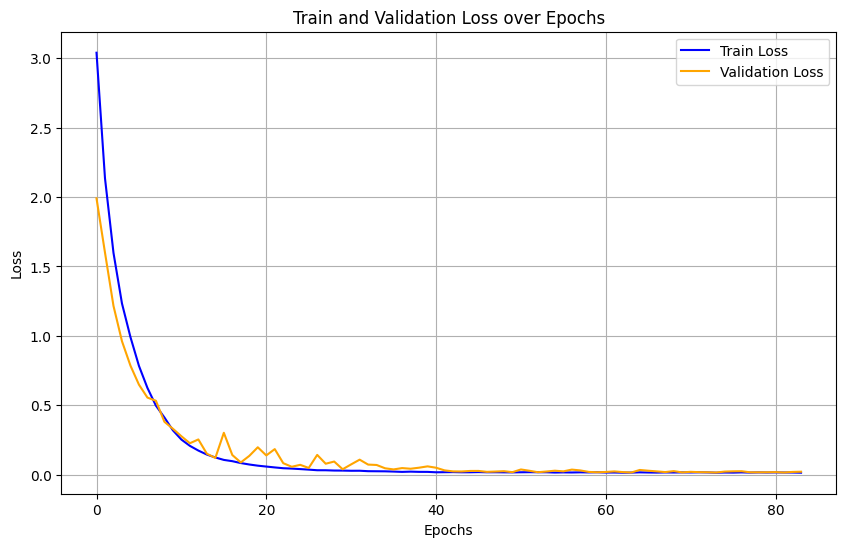

In [33]:
def build_model(input_shape):
    model = Sequential()
    # Layer LSTM đầu tiên
    model.add(LSTM(units=128, input_shape=input_shape, return_sequences=True, kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())  # Thêm BatchNormalization
    model.add(Dropout(0.4))
    
    # Layer LSTM thứ hai
    model.add(LSTM(units=64, return_sequences=True, kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    
    # Layer LSTM cuối cùng
    model.add(LSTM(units=32, kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    
    # Dense Layer đầu ra
    model.add(Dense(1))
    
    # Compile model
    model.compile(loss='mean_absolute_error', optimizer=Adam(learning_rate=0.001))
    return model

# Định nghĩa input_shape
input_shape = (x_train.shape[1], x_train.shape[2])
model = build_model(input_shape)

# Callbacks
save_model_path = "save_models/FPT_model.keras"
callbacks = [
    ModelCheckpoint(save_model_path, monitor='val_loss', verbose=2, save_best_only=True, mode='auto'),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=2),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=2)  # Sử dụng 'val_loss' thay vì 'loss'
]

# Huấn luyện mô hình
history = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=100,
    batch_size=64,
    verbose=2,
    callbacks=callbacks
)

# Vẽ biểu đồ loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Train and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [13]:
# save_model_path = "models/FPT_model.keras"
# Tải mô hình tốt nhất
final_model = load_model(save_model_path)

In [14]:
# Dự đoán trên tập train
y_train_predict = final_model.predict(x_train)
y_train_predict = sc.inverse_transform(y_train_predict)
y_train = sc.inverse_transform(y_train.reshape(-1, 1))

111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step


In [15]:
#xử lý dữ liệu test
test = df1[len(train_data)-50:].values
test = test.reshape(-1,1)
sc_test = sc.transform(test)

x_test = []
for i in range(50,test.shape[0]):
  x_test.append(sc_test[i-50:i,0])
x_test = np.array(x_test)
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

#dữ liệu test
y_test = data[int(len(df) * 0.8):] #giá thực
y_test_predict = final_model.predict(x_test)
y_test_predict = sc.inverse_transform(y_test_predict) #giá dự đoán

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


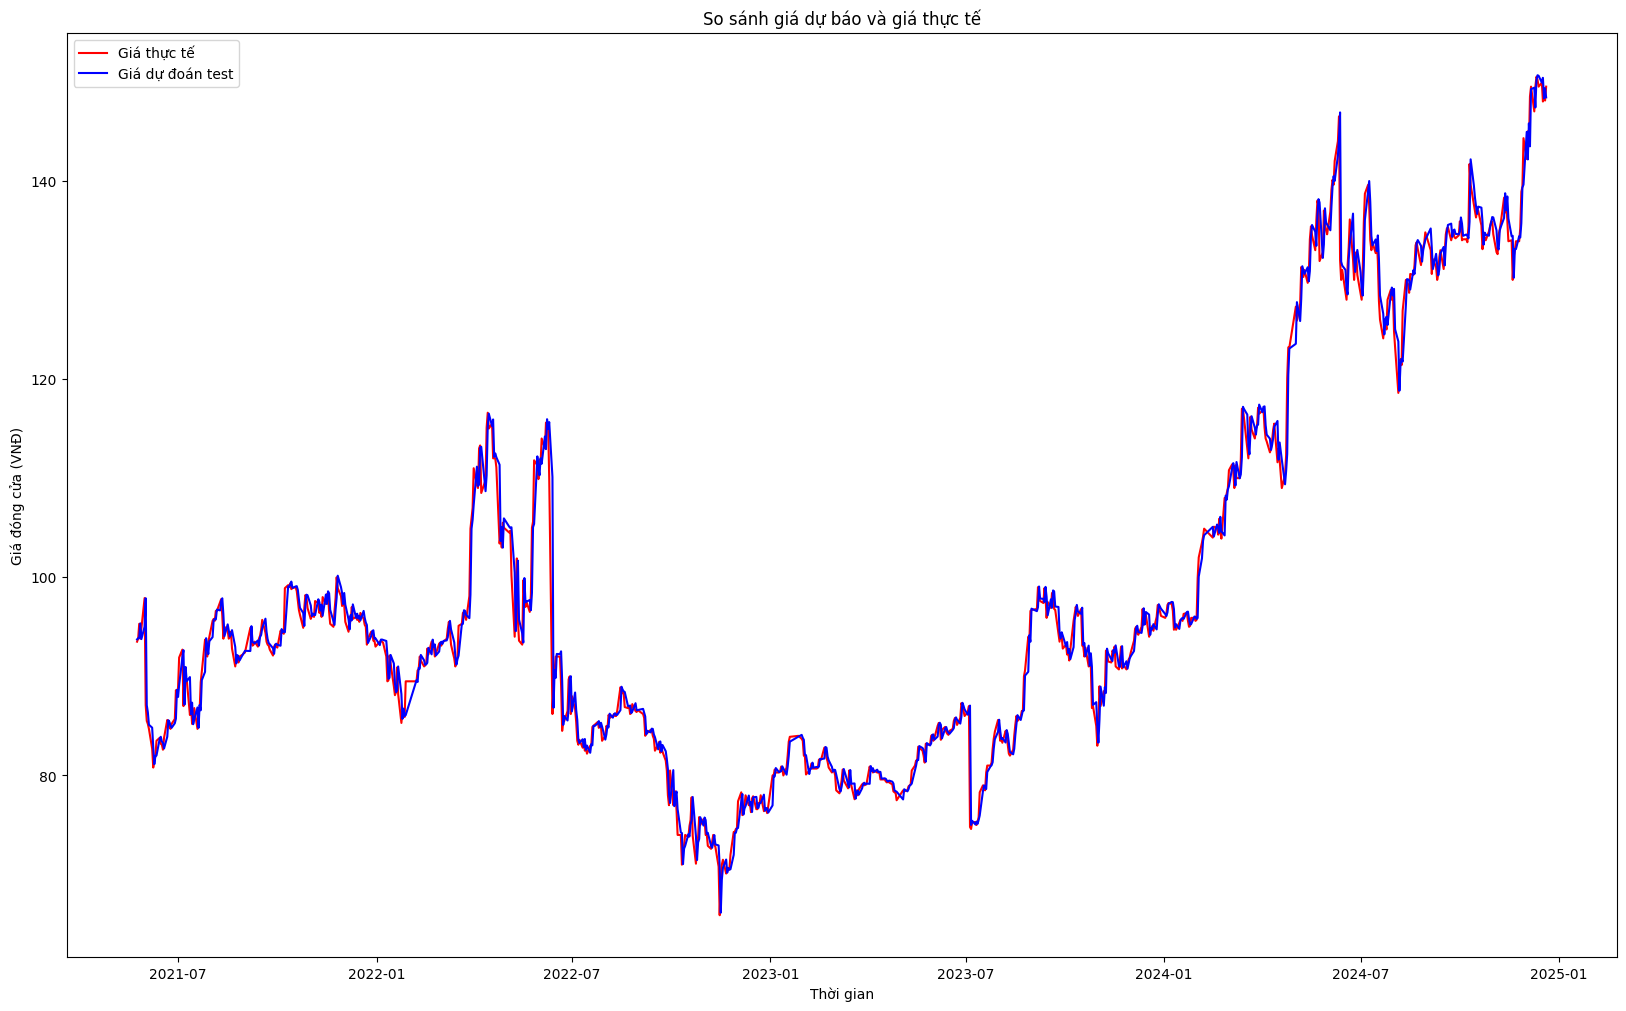

In [17]:
# Chọn dữ liệu cho test_data1
num_test_predictions = len(y_test_predict)
test_data1 = df.iloc[-num_test_predictions:].copy()
plt.figure(figsize=(20, 12))
if 'Ngay' in test_data1.columns:
    plt.plot(test_data1['Ngay'], test_data1['GiaDongCua'], label='Giá thực tế', color='red')
else:
    raise KeyError("Cột 'Ngày' không tồn tại trong test_data1.")

test_data1 = test_data1.copy()
test_data1['Dự đoán'] = y_test_predict.flatten()
plt.plot(test_data1['Ngay'], test_data1['Dự đoán'], label='Giá dự đoán test', color='blue')
plt.title('So sánh giá dự báo và giá thực tế')
plt.xlabel('Thời gian')
plt.ylabel('Giá đóng cửa (VNĐ)')
plt.legend()
plt.show()


In [18]:
print('--- Kết quả trên tập train ---')
# R2 score
print('Độ phù hợp tập train (R2):', r2_score(y_train, y_train_predict))

# MAE
print('Sai số tuyệt đối trung bình trên tập train (VNĐ):', mean_absolute_error(y_train, y_train_predict))

# MAPE
print('Phần trăm sai số tuyệt đối trung bình trên tập train:', mean_absolute_percentage_error(y_train, y_train_predict) * 100)

# RMSE
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_predict))
print('RMSE trên tập train (VNĐ):', rmse_train)

# Accuracy (dựa trên RMSE và biên độ giá trị thực tế)
range_y_train = np.max(y_train) - np.min(y_train)
accuracy_train = 1 - (rmse_train / range_y_train)
print('Độ chính xác trên tập train (%):', accuracy_train * 100)

# F1 Score (Chuyển thành bài toán phân loại)
error_threshold = 10  # Ngưỡng sai số
y_train_class = [1 if abs(y - yp) < error_threshold else 0 for y, yp in zip(y_train, y_train_predict)]
y_train_pred_class = [1 if abs(y - yp) < error_threshold else 0 for y, yp in zip(y_train, y_train_predict)]
f1_train = f1_score(y_train_class, y_train_pred_class)
print('F1 Score trên tập train:', f1_train)
print("----------------------------------------------------")

--- Kết quả trên tập train ---
Độ phù hợp tập train (R2): 0.9971253259014062
Sai số tuyệt đối trung bình trên tập train (VNĐ): 1.3246784977448844
Phần trăm sai số tuyệt đối trung bình trên tập train: 1.50310781818651
RMSE trên tập train (VNĐ): 3.9880427828792833
Độ chính xác trên tập train (%): 99.34910351185258
F1 Score trên tập train: 1.0
----------------------------------------------------


In [19]:
y_test = data[-len(y_test_predict):]

In [20]:
print('--- Kết quả trên tập test ---')
# R2 score
print('Độ phù hợp tập test (R2):', r2_score(y_test, y_test_predict))

# MAE
print('Sai số tuyệt đối trung bình trên tập test (VNĐ):', mean_absolute_error(y_test, y_test_predict))

# MAPE
print('Phần trăm sai số tuyệt đối trung bình trên tập test:', mean_absolute_percentage_error(y_test, y_test_predict) * 100)

# RMSE
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_predict))
print('RMSE trên tập test (VNĐ):', rmse_test)

# Accuracy (dựa trên RMSE và biên độ giá trị thực tế)
range_y_test = np.max(y_test) - np.min(y_test)
accuracy_test = 1 - (rmse_test / range_y_test)
print('Độ chính xác trên tập test (%):', accuracy_test * 100)

# F1 Score (Chuyển thành bài toán phân loại)
y_test_class = [1 if abs(y - yp) < error_threshold else 0 for y, yp in zip(y_test, y_test_predict)]
y_test_pred_class = [1 if abs(y - yp) < error_threshold else 0 for y, yp in zip(y_test, y_test_predict)]
f1_test = f1_score(y_test_class, y_test_pred_class)
print('F1 Score trên tập test:', f1_test)
print("----------------------------------------------------")

--- Kết quả trên tập test ---
Độ phù hợp tập test (R2): 0.9901119636346976
Sai số tuyệt đối trung bình trên tập test (VNĐ): 1.1890992229321644
Phần trăm sai số tuyệt đối trung bình trên tập test: 1.2024250890458033
RMSE trên tập test (VNĐ): 1.9582880434480208
Độ chính xác trên tập test (%): 97.68523871932858
F1 Score trên tập test: 1.0
----------------------------------------------------


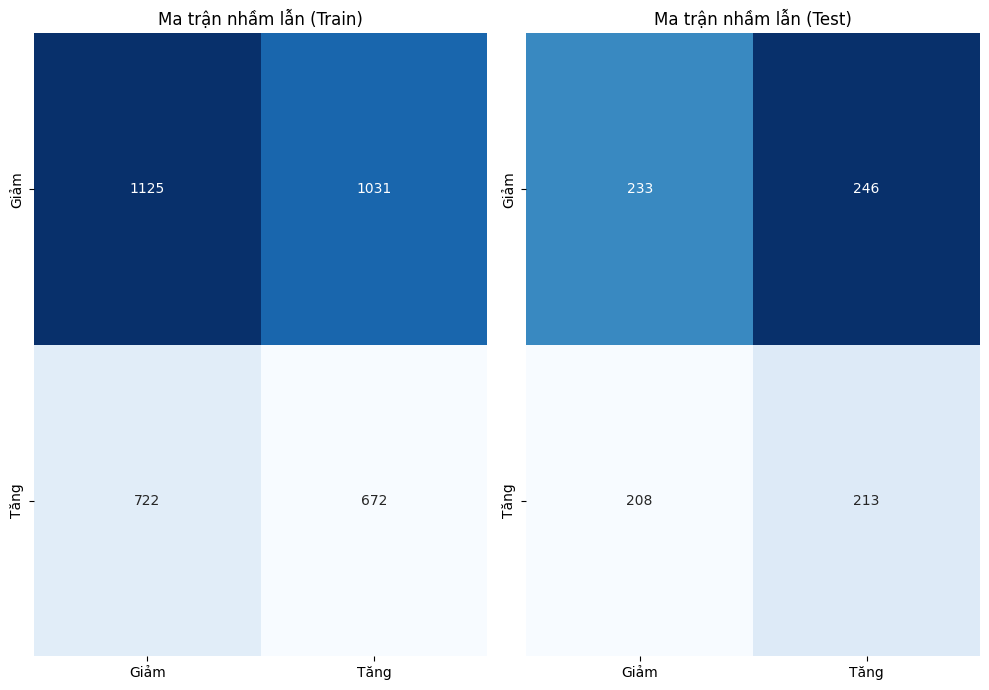

In [28]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def create_labels(data):
    return [1 if data[i] > data[i-1] else 0 for i in range(1, len(data))]

# Chuyển đổi giá trị thực tế và dự đoán thành nhãn phân loại
y_train_labels = create_labels(y_train)
y_train_predict_labels = create_labels(y_train_predict.flatten())

y_test_labels = create_labels(y_test)
y_test_predict_labels = create_labels(y_test_predict.flatten())

# Tạo ma trận nhầm lẫn cho tập train
cm_train = confusion_matrix(y_train_labels, y_train_predict_labels)
cm_test = confusion_matrix(y_test_labels, y_test_predict_labels)

# Hiển thị ma trận nhầm lẫn
plt.figure(figsize=(10, 7))

# Ma trận nhầm lẫn cho tập train
plt.subplot(1, 2, 1)
sns.heatmap(cm_train, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=["Giảm", "Tăng"], yticklabels=["Giảm", "Tăng"])
plt.title("Ma trận nhầm lẫn (Train)")

# Ma trận nhầm lẫn cho tập test
plt.subplot(1, 2, 2)
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=["Giảm", "Tăng"], yticklabels=["Giảm", "Tăng"])
plt.title("Ma trận nhầm lẫn (Test)")

plt.tight_layout()
plt.show()